In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Cleaning the Student Essay Data
I've got all of the student data I could ever need, with something like 650 essays from 100 or so different topics. I should be able to clean them all at once. I will also make sure that this step is done in a functional way in case I need to scrape more data.

In [2]:
df_student = pickle.load(open('../uk_students.pkl', 'rb'))
print('Number of student essays:', len(df_student))

# We can use this column to look at some summary statistics
df_student['joined'] = ([' '.join(each) for each in df_student.loc[:, 'text']])

df_student.head()

Number of student essays: 675


,subject,text,title,student,joined
0,Ecommerce,"[\n, \n, \n, \n, \n, Face of consumerism throu...",Impact of E-commerce on the Hospitality Industry,1,\n \n \n \n \n Face of consumerism through e-c...
1,Drama,"[\n, \n, \n, \n, \n, ped importance, price el...",Importance of Elasticity Demand,1,"\n \n \n \n \n ped importance, price elastici..."
2,Design,"[\n, \n, \n, \n, \n, To export a reference to ...",Posters of the Second World War - An Analysis,1,\n \n \n \n \n To export a reference to this a...
3,Data Analysis,"[\n, \n, \n, \n, \n, When we talk about the Ma...",Mathematical description of OFDM,1,\n \n \n \n \n When we talk about the Mathemat...
4,Cultural Studies,"[\n, \n, \n, \n, \n, The culture of the educat...",Cultural Analysis of Pakistan,1,\n \n \n \n \n The culture of the educational ...


In [3]:
lengths = pd.Series([len(each) for each in df_student.joined])
df_student['lengths'] = lengths
lengths.describe()

count      675.000000
mean     14078.758519
std      10753.897797
min          9.000000
25%       7998.000000
50%      11906.000000
75%      16596.500000
max      62832.000000
dtype: float64

Looks like we have some small essays

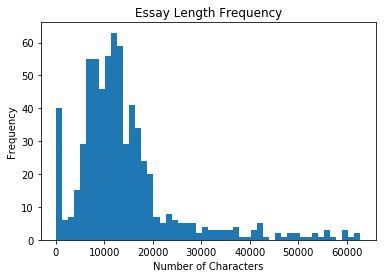

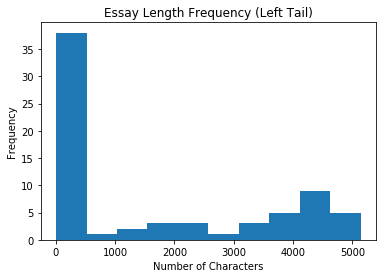

In [4]:
# I'm using a lot of bins because it is easier to see that there are a lot of very tiny essays
plt.hist(df_student.lengths, bins=50)
plt.title('Essay Length Frequency')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.show()

# Let's look a little closer at the left side
plt.hist(sorted(lengths)[:70], bins=10)
plt.title('Essay Length Frequency (Left Tail)')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
# plt.xlim([0, 1000])
plt.show()

Let's go ahead and throw those small essays out

In [5]:
df_student = df_student[df_student['lengths'] > 1000]
df_student.reset_index(drop=True, inplace=True)

Okay, wow. That is a pretty big relief. The paragraphs are already separated for us, there are always 5 newlines at the beginning (you'll have to take my word for it), and the last two paragraphs are always a couple random characters and a statement about exporting the document. This will be really easy to clean up.

In [6]:
for i, text in enumerate(df_student.loc[:, 'text']):
    df_student.at[i, 'text'] = text[5:-2]
df_student.head()

,subject,text,title,student,joined,lengths
0,Ecommerce,[Face of consumerism through e-commerce has ra...,Impact of E-commerce on the Hospitality Industry,1,\n \n \n \n \n Face of consumerism through e-c...,8668
1,Drama,"[ ped importance, price elasticity importance,...",Importance of Elasticity Demand,1,"\n \n \n \n \n ped importance, price elastici...",8739
2,Data Analysis,[When we talk about the Mathematical descripti...,Mathematical description of OFDM,1,\n \n \n \n \n When we talk about the Mathemat...,21128
3,Cultural Studies,[The culture of the educational system of Paki...,Cultural Analysis of Pakistan,1,\n \n \n \n \n The culture of the educational ...,10377
4,Criminology,[John Dillinger was one of the Midwest and our...,"Bank Robber: John Dillinger, a Biography",1,\n \n \n \n \n John Dillinger was one of the M...,15710


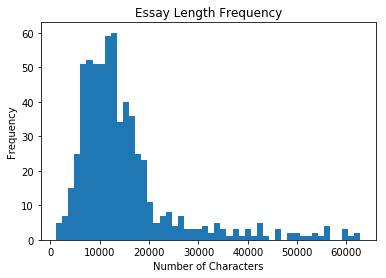

In [7]:
# I'm using a lot of bins because it is easier to see that there are a lot of very tiny essays
plt.hist(df_student.lengths, bins=50)
plt.title('Essay Length Frequency')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.show()

# Header

# Header

# Header

# Header

# Header

# Header